### Nome: Edgar Lopes Banhesse - RA: 993396
### Disciplina: IA369Y - Computação Afetiva - 2º Semestre 2018

### T3 - Análise e Síntese de Emoções em Conteúdo Multimídia
### Atividade 6 - Tutorial: Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV


Este jupyter notebook contém os passos realizados para reproduzir o tutorial de van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV. Disponível em http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/

Para realizar o tutorial é necessário preparar o ambiente. Desta forma, os softwares abaixo foram instalados:

- Python (anaconda + jupyter notebook)
- DLib
- OpenCV
- SKLearn (já instalado com anaconda)

#### 1. Preparação do ambiente

O sistema operacional utilizado para realizar o tutorial foi o Windows 10.

##### 1.1 Instalação do Anaconda, Jupyter Notebook e Python
Para instalar o Anaconda, Jupyter Notebook e Python foi utilizado o tutorial:

https://medium.com/@neuralnets/beginners-quick-guide-for-handling-issues-launching-jupyter-notebook-for-python-using-anaconda-8be3d57a209b

##### 1.2 Instalação da biblioteca DLib para extrair marcos faciais
Ao realizar uma pesquisa pela internet foi encontrado um pacote com a biblioteca DLib para Anaconda em Windows.
Para instalar a biblioteca foi utilizado o comando:

$ conda install -c conda-forge dlib=19.4

##### 1.3 Instalação da biblioteca OpenCV
Para Python 3.6 foi feito o download do binário opencv_python-3.4.3+contrib-cp36-cp36m-win_amd64.whl do site https://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv e instalado manualmente.

$ pip install opencv_python-3.4.3+contrib-cp36-cp36m-win_amd64.whl

In [18]:
# Testes para verificar a instalação do Anaconda, Jupyter Notebook, Python, DLib e OpenCV

# Anaconda, Python e Jupyter Notebook
print("Versão do Anaconda, Python e Jupyter Notebook: ")
!python --version
!conda list ipython

# DLib
print("Versão da biblioteca DLib: ")
import dlib
print(dlib.__version__)

# OpenCV
print("Versão da biblioteca OpenCV: ")
import cv2
print(cv2.__version__)

Versão do Anaconda, Python e Jupyter Notebook: 


Python 3.6.5 :: Anaconda, Inc.


# packages in environment at C:\ProgramData\Anaconda3:
#
# Name                    Version                   Build  Channel
ipython                   6.4.0                    py36_0  
ipython_genutils          0.2.0            py36h3c5d0ee_0  
Versão da biblioteca DLib: 
19.4.0
Versão da biblioteca OpenCV: 
3.4.3


#### 2. Detecção e captura de face via webcam
O código abaixo disponível no tutorial foi utilizado para detectar e capturar uma face via webcam.

In [7]:
#Import required modules
import cv2
import dlib

#Set up some required objects
video_capture = cv2.VideoCapture(0) #Webcam object
detector = dlib.get_frontal_face_detector() #Face detector
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Landmark identifier. Set the filename to whatever you named the downloaded file

while True:
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)

    detections = detector(clahe_image, 1) #Detect the faces in the image

    for k,d in enumerate(detections): #For each detected face
        
        shape = predictor(clahe_image, d) #Get coordinates
        for i in range(1,68): #There are 68 landmark points on each face
            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2) #For each point, draw a red circle with thickness2 on the original frame

    cv2.imshow("image", frame) #Display the frame

    if cv2.waitKey(1) & 0xFF == ord('q'): #Exit program when the user presses 'q'
        break

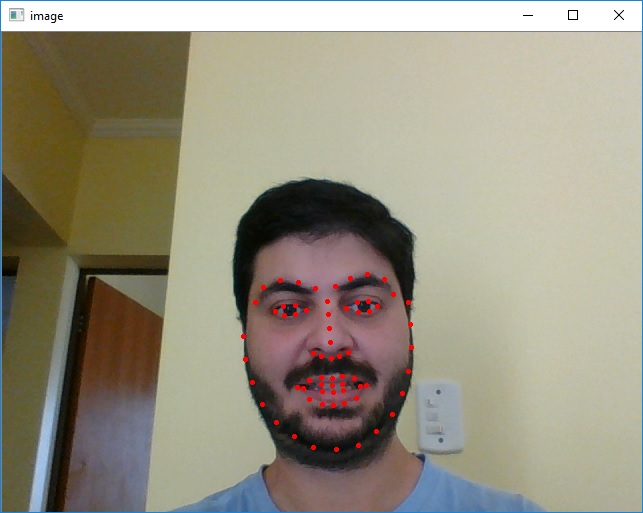

In [2]:
# Imagem de minha face detectada e capturada
from IPython.display import Image, display
display(Image(filename='face-detect-capture-elb.jpg', embed=True))

#### 3. Extração de features de faces

O código para detecção e captura de face foi então modificado conforme tutorial para extrair as coordenadas dos marcos faciais (features) através da função get_landmarks().

In [3]:
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        for x, y in zip(xlist, ylist): #Store all landmarks in one list in the format x1,y1,x2,y2,etc.
            landmarks.append(x)
            landmarks.append(y)
    if len(detections) > 0:
        return landmarks
    else: #If no faces are detected, return error message to other function to handle
        landmarks = "error"
        return landmarks

Devido a movimentação ou inclinação da face a extração dos marcos faciais (features) pode ser um problema.
Desta forma, o autor propõe normalizar as coordenadas dos marcos:

<code>xnorm = [(i-min(xlist))/(max(xlist)-min(xlist)) for i in xlist]
ynorm = [(i-min(ylist))/(max(ylist)-min(ylist)) for i in ylist]</code>

Como esas abordagem provoca perda de informação ao comparar duas fotos muito similares, uma alternativa seria calcular a posição dos pontos em relação a um centro de gravidade facial, conforme ilustrado abaixo no tutorial.

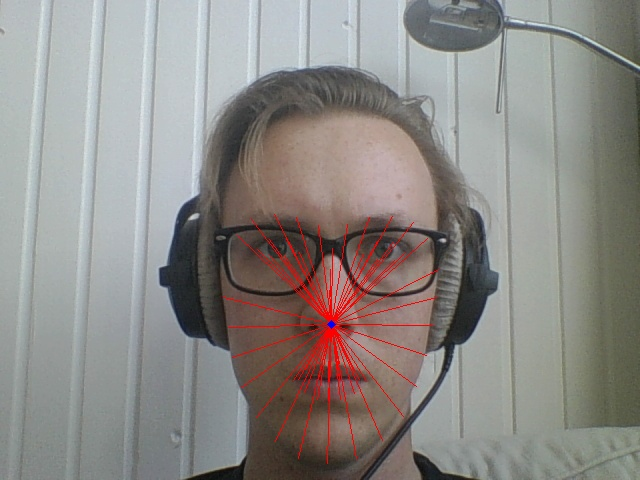

In [4]:
# Imagem dos pontos calculados em relação a um centro de gravidade facial
from IPython.display import Image, display
display(Image(filename='face-center-gravity.jpg', embed=True))

O autor descreve em seu tutorial algumas razões para utilizar o centro de gravidade da face ao invés da ponta do nariz como centro dos pontos, tais como:

1) Tipos diferentes de nariz introduziriam variância nos dados.

2) A distância ou inclinação da cabeça pode confundir o classificador.

Desta forma, a função get_landmarks() foi modificada para tratar o centro de gravidade das coordenadas.

In [5]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

#### 4. Classificação de emoções do dataset Cohn-Kanade

O último passo do tutorial trata da classificação de emoções de um dataset usando marcos faciais.

##### 4.1 Preparação do dataset Cohn-Kanade
- A classificação foi feita no dataset Cohn-Kanade (Kanade, T., Cohn, J. F., & Tian, Y. (2000)).
- Foi feito o download do dataset CK+ disponível em http://www.consortium.ri.cmu.edu/ckagree/
- O dataset foi preparado conforme tutorial anterior do mesmo autor disponível em
http://www.paulvangent.com/2016/04/01/emotion-recognition-with-python-opencv-and-a-face-dataset/

O dataset CK+ consiste de uma sequência de imagens com progressão de neutro para a emoção rotulada em cada uma das pastas de imagem. Veja abaixo.

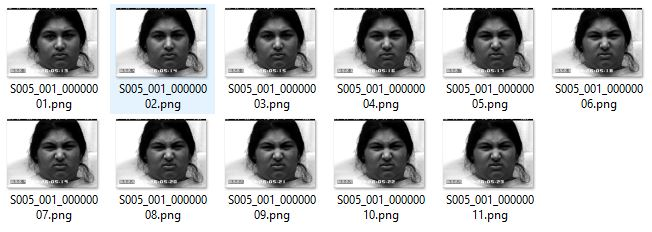

In [17]:
# Imagem de uma amostra do dataset CK+
from IPython.display import Image, display
display(Image(filename='ckp-dataset.jpg', embed=True))

Para realizar a classificação é necessário apenas a imagem com a emoção final das progressões.
Por isso, um script que seleciona essas imagens de acordo com o rótulo emocional e coloca as mesmas numa nova estrutura de diretórios agrupados por rótulo emocional será executado.

A seguinte estrutura de diretórios foi criada:

- source_emotion - contém os arquivos .txt com as emoções das imagens do dataset ck+;
- source_images - contém as imagens do dataset ck+;
- sorted_set - contém os diretórios com as emoções ("neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"), onde o script colocará as imagens agrupadas pelas emoções.

In [1]:
import glob
from shutil import copyfile

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotion order
participants = glob.glob("source_emotion\\*") #Returns a list of all folders with participant numbers

for x in participants:
    part = "%s" %x[-4:] #store current participant number
    for sessions in glob.glob("%s\\*" %x): #Store list of sessions for current participant
        for files in glob.glob("%s\\*" %sessions):
            current_session = files[20:-30]
            file = open(files, 'r')
            
            emotion = int(float(file.readline())) #emotions are encoded as a float, readline as float, then convert to integer.
            
            sourcefile_emotion = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[-1] #get path for last image in sequence, which contains the emotion
            sourcefile_neutral = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[0] #do same for neutral image
            
            dest_neut = "sorted_set\\neutral\\%s" %sourcefile_neutral[25:] #Generate path to put neutral image
            dest_emot = "sorted_set\\%s\\%s" %(emotions[emotion], sourcefile_emotion[25:]) #Do same for emotion containing image
            
            copyfile(sourcefile_neutral, dest_neut) #Copy file
            copyfile(sourcefile_emotion, dest_emot) #Copy file

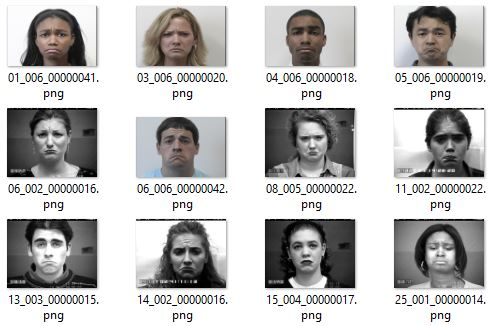

In [9]:
# Imagem de uma amostra de tristeza
from IPython.display import Image, display
display(Image(filename='sorted-sadness.jpg', embed=True))

Para maximizar o desempenho do classificador é necessário realizar um pré-processamento das imagens. Foi criado um diretório chamado dataset e dentro desse diretório foram criados diretórios para as emoções ("neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise").

Após, duas etapas foram realizadas:

1) Crop - foi utilizado o filtro HAAR da biblioteca OpenCV para assegurar que apenas as imagens das faces sejam selecionadas.

2) Conversão das imagens para escala de cinza.

Conforme tutorial, quatro classificadores pré-treinados fornecidos pela OpenCV em http://www.paulvangent.com/wp-content/uploads/2016/04/OpenCV_FaceCascade.zip foram baixados e utilizados.

Para realizar esse tratamento nas imagens  script abaixo foi executado.

In [3]:
import cv2
import glob

faceDet = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
faceDet_two = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
faceDet_three = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
faceDet_four = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotions

def detect_faces(emotion):
    files = glob.glob("sorted_set\\%s\\*" %emotion) #Get list of all images with emotion

    filenumber = 0
    for f in files:
        frame = cv2.imread(f) #Open image
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
        
        #Detect face using 4 different classifiers
        face = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_two = faceDet_two.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_three = faceDet_three.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
        face_four = faceDet_four.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

        #Go over detected faces, stop at first detected face, return empty if no face.
        if len(face) == 1:
            facefeatures = face
        elif len(face_two) == 1:
            facefeatures = face_two
        elif len(face_three) == 1:
            facefeatures = face_three
        elif len(face_four) == 1:
            facefeatures = face_four
        else:
            facefeatures = ""
        
        #Cut and save face
        for (x, y, w, h) in facefeatures: #get coordinates and size of rectangle containing face
            print("face found in file: %s" %f)
            gray = gray[y:y+h, x:x+w] #Cut the frame to size
            
            try:
                out = cv2.resize(gray, (350, 350)) #Resize face so all images have same size
                cv2.imwrite("dataset\\%s\\%s.jpg" %(emotion, filenumber), out) #Write image
            except:
               pass #If error, pass file
        filenumber += 1 #Increment image number

for emotion in emotions: 
    detect_faces(emotion) #Call functions

face found in file: sorted_set\neutral\00_002_00000001.png
face found in file: sorted_set\neutral\00_005_00000001.png
face found in file: sorted_set\neutral\00_006_00000001.png
face found in file: sorted_set\neutral\01_001_00000001.png
face found in file: sorted_set\neutral\01_002_00000001.png
face found in file: sorted_set\neutral\01_004_00000001.png
face found in file: sorted_set\neutral\01_006_00000001.png
face found in file: sorted_set\neutral\02_001_00000001.png
face found in file: sorted_set\neutral\02_002_00000001.png
face found in file: sorted_set\neutral\02_003_00000001.png
face found in file: sorted_set\neutral\02_004_00000001.png
face found in file: sorted_set\neutral\02_009_00000001.png
face found in file: sorted_set\neutral\03_001_00000001.png
face found in file: sorted_set\neutral\03_002_00000001.png
face found in file: sorted_set\neutral\03_006_00000001.png
face found in file: sorted_set\neutral\04_001_00000001.png
face found in file: sorted_set\neutral\04_002_00000001.p

face found in file: sorted_set\neutral\42_001_00000001.png
face found in file: sorted_set\neutral\42_002_00000001.png
face found in file: sorted_set\neutral\42_004_00000001.png
face found in file: sorted_set\neutral\42_006_00000001.png
face found in file: sorted_set\neutral\44_001_00000001.png
face found in file: sorted_set\neutral\44_003_00000001.png
face found in file: sorted_set\neutral\44_006_00000001.png
face found in file: sorted_set\neutral\45_004_00000001.png
face found in file: sorted_set\neutral\45_005_00000001.png
face found in file: sorted_set\neutral\46_001_00000001.png
face found in file: sorted_set\neutral\46_002_00000001.png
face found in file: sorted_set\neutral\46_003_00000001.png
face found in file: sorted_set\neutral\46_004_00000001.png
face found in file: sorted_set\neutral\47_002_00000001.png
face found in file: sorted_set\neutral\48_002_00000001.png
face found in file: sorted_set\neutral\49_002_00000001.png
face found in file: sorted_set\neutral\50_001_00000001.p

face found in file: sorted_set\neutral\89_002_00000001.png
face found in file: sorted_set\neutral\89_003_00000001.png
face found in file: sorted_set\neutral\90_002_00000001.png
face found in file: sorted_set\neutral\90_006_00000001.png
face found in file: sorted_set\neutral\90_007_00000001.png
face found in file: sorted_set\neutral\91_001_00000001.png
face found in file: sorted_set\neutral\91_003_00000001.png
face found in file: sorted_set\neutral\92_001_00000001.png
face found in file: sorted_set\neutral\92_003_00000001.png
face found in file: sorted_set\neutral\92_004_00000001.png
face found in file: sorted_set\neutral\93_001_00000001.png
face found in file: sorted_set\neutral\93_004_00000001.png
face found in file: sorted_set\neutral\94_001_00000001.png
face found in file: sorted_set\neutral\94_004_00000001.png
face found in file: sorted_set\neutral\95_001_00000001.png
face found in file: sorted_set\neutral\95_002_00000001.png
face found in file: sorted_set\neutral\95_006_00000001.p

face found in file: sorted_set\disgust\81_008_00000011.png
face found in file: sorted_set\disgust\82_007_00000010.png
face found in file: sorted_set\disgust\85_004_00000017.png
face found in file: sorted_set\disgust\87_004_00000012.png
face found in file: sorted_set\disgust\88_004_00000020.png
face found in file: sorted_set\disgust\90_006_00000011.png
face found in file: sorted_set\disgust\95_006_00000013.png
face found in file: sorted_set\disgust\96_003_00000012.png
face found in file: sorted_set\disgust\97_004_00000030.png
face found in file: sorted_set\disgust\98_003_00000013.png
face found in file: sorted_set\disgust\99_007_00000012.png
face found in file: sorted_set\fear\01_004_00000056.png
face found in file: sorted_set\fear\02_003_00000016.png
face found in file: sorted_set\fear\02_004_00000052.png
face found in file: sorted_set\fear\04_004_00000015.png
face found in file: sorted_set\fear\06_004_00000038.png
face found in file: sorted_set\fear\11_003_00000014.png
face found in f

face found in file: sorted_set\surprise\14_001_00000029.png
face found in file: sorted_set\surprise\15_001_00000008.png
face found in file: sorted_set\surprise\16_001_00000014.png
face found in file: sorted_set\surprise\17_001_00000014.png
face found in file: sorted_set\surprise\19_001_00000011.png
face found in file: sorted_set\surprise\22_001_00000012.png
face found in file: sorted_set\surprise\22_001_00000030.png
face found in file: sorted_set\surprise\24_001_00000014.png
face found in file: sorted_set\surprise\25_007_00000009.png
face found in file: sorted_set\surprise\26_001_00000015.png
face found in file: sorted_set\surprise\26_004_00000012.png
face found in file: sorted_set\surprise\27_001_00000017.png
face found in file: sorted_set\surprise\29_002_00000011.png
face found in file: sorted_set\surprise\30_001_00000018.png
face found in file: sorted_set\surprise\31_001_00000016.png
face found in file: sorted_set\surprise\32_001_00000022.png
face found in file: sorted_set\surprise\

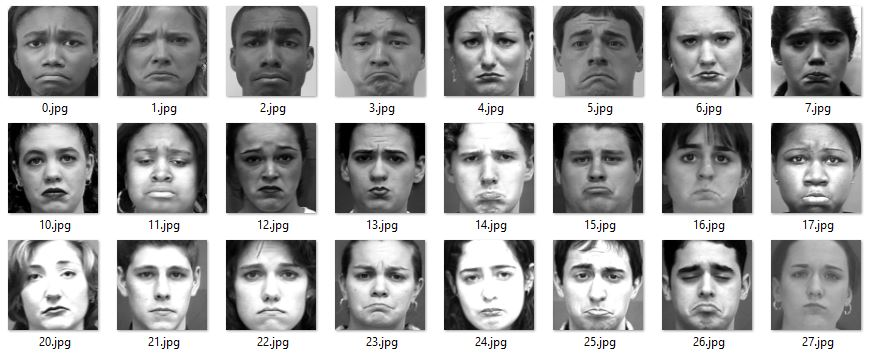

In [13]:
# Resultado, após executar o script de tratamento do dataset ck+ para obter o crop e grayscale
from IPython.display import Image, display
display(Image(filename='crop-grayscale-sadness.jpg', embed=True))

##### 4.2 Execução do Classificador Fisher Face
Após preparar o dataset foi realizado uma divisão aleatória do mesmo, 80% para treinamento e 20% para teste.
A classificação foi então executada pelo script 10 vezes para derivar uma média do desempenho do classificador.
O script com o classificador fisher face está disponível no tuturial http://www.paulvangent.com/2016/04/01/emotion-recognition-with-python-opencv-and-a-face-dataset/

In [14]:
import cv2
import glob
import random
import numpy as np
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list
fishface = cv2.face.FisherFaceRecognizer_create() #Initialize fisher face classifier

data = {}
def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            training_data.append(gray) #append image array to training data list
            training_labels.append(emotions.index(emotion))
        for item in prediction: #repeat above process for prediction set
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            prediction_data.append(gray)
            prediction_labels.append(emotions.index(emotion))
    return training_data, training_labels, prediction_data, prediction_labels
def run_recognizer():
    training_data, training_labels, prediction_data, prediction_labels = make_sets()
    print("training fisher face classifier")
    print("size of training set is:", len(training_labels), "images")
    fishface.train(training_data, np.asarray(training_labels))
    print("predicting classification set")
    cnt = 0
    correct = 0
    incorrect = 0
    for image in prediction_data:
        pred, conf = fishface.predict(image)
        if pred == prediction_labels[cnt]:
            correct += 1
            cnt += 1
        else:
            incorrect += 1
            cnt += 1
    return ((100*correct)/(correct + incorrect))
#Now run it
metascore = []
for i in range(0,10):
    correct = run_recognizer()
    print("got", correct, "percent correct!")
    metascore.append(correct)
print("\n\nend score:", np.mean(metascore), "percent correct!")

training fisher face classifier
size of training set is: 371 images
predicting classification set
got 73.33333333333333 percent correct!
training fisher face classifier
size of training set is: 371 images
predicting classification set
got 75.55555555555556 percent correct!
training fisher face classifier
size of training set is: 371 images
predicting classification set
got 74.44444444444444 percent correct!
training fisher face classifier
size of training set is: 371 images
predicting classification set
got 73.33333333333333 percent correct!
training fisher face classifier
size of training set is: 371 images
predicting classification set
got 71.11111111111111 percent correct!
training fisher face classifier
size of training set is: 371 images
predicting classification set
got 76.66666666666667 percent correct!
training fisher face classifier
size of training set is: 371 images
predicting classification set
got 75.55555555555556 percent correct!
training fisher face classifier
size of t

##### 4.3 Execução do Classificador Linear SVM
Após preparar o dataset foi realizado uma divisão aleatória do mesmo, 80% para treinamento e 20% para teste.
A classificação foi então executada pelo script 10 vezes para derivar uma média do desempenho do classificador.

In [16]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values
#data['landmarks_vectorised'] = []

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print((" working on %s" %emotion))
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
    
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels   

accur_lin = []
for i in range(0,10):
    print(("Making sets %s" %i)) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()

    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print(("training SVM linear %s" %i)) #train SVM
    clf.fit(npar_train, training_labels)

    print(("getting accuracies %s" %i)) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print("linear: ", pred_lin)
    accur_lin.append(pred_lin) #Store accuracy in a list

print(("Mean value lin svm: %s" %np.mean(accur_lin))) #FGet mean accuracy of the 10 runs

Making sets 0
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 0
getting accuracies 0
linear:  0.7662337662337663
Making sets 1
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 1
getting accuracies 1
linear:  0.8571428571428571
Making sets 2
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 2
getting accuracies 2
linear:  0.7662337662337663
Making sets 3
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 3
getting accuracies 3
linear:  0.7402597402597403
Making sets 4
 working o

#### 5. Conclusões

Comparando o resultado dos classificadores: Fisher Face sem o uso de marcos faciais e Linear SVM com o uso de marcos faciais, nota-se que o desempenho do classificador Linear SVM com o uso de marcos faciais foi superior.

O tutorial compara o desempenho de outros classificadores, mostrando que o SVM linear possui melhor desempenho para vários casos com uso de marcos faciais (features).

A utilização de outras features, tais como: (vetorização, centro de gravidade) não aumentou o desempenho do classificador.

O tutorial é muito interessante para introduzir o uso da bibliotecas Python para a detecção e captura de emoções em imagens rotuladas com o usu de modelos de aprendizado de máquina.

O algoritmo SVM Linear mostrou-se mais eficiante e portanto mais apropriado para a classificação.

#### 6. Referências
- van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV. A tech blog about fun things with Python and embedded electronics - http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/
- van Gent, P. (2016). Emotion Recognition With Python, OpenCV and a Face Dataset - http://www.paulvangent.com/2016/04/01/emotion-recognition-with-python-opencv-and-a-face-dataset/
- Kanade, T., Cohn, J. F., & Tian, Y. (2000). Comprehensive database for facial expression analysis. Proceedings of the Fourth IEEE International Conference on Automatic Face and Gesture Recognition (FG'00), Grenoble, France, 46-53.
- Lucey, P., Cohn, J. F., Kanade, T., Saragih, J., Ambadar, Z., & Matthews, I. (2010). The Extended Cohn-Kanade Dataset (CK+): A complete expression dataset for action unit and emotion-specified expression. Proceedings of the Third International Workshop on CVPR for Human Communicative Behavior Analysis (CVPR4HB 2010), San Francisco, USA, 94-101.
- Cohn-Kanade (CK and CK+) database Download Site - http://www.consortium.ri.cmu.edu/ckagree/
- Beginner’s Guide for installing Jupyter Notebook using Anaconda Distribution - https://medium.com/@neuralnets/beginners-quick-guide-for-handling-issues-launching-jupyter-notebook-for-python-using-anaconda-8be3d57a209b
- Unofficial Windows Binaries for Python Extension Packages - https://www.lfd.uci.edu/~gohlke/pythonlibs/